In [52]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from pandas import ExcelWriter
import pandas as pd
import os

# Part 1

In [53]:
def read_file(filename, alpha, beta):
    if open(filename, 'r') == 0:
        print("File not found or cannot be opened")
        return None
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()

    dimension = int(lines[0].strip())
    connectivity = lines[1:]
    huckel_matrix = np.identity(dimension, dtype=np.float64)
    huckel_matrix = huckel_matrix*alpha
    for line in connectivity:
        i, j = map(int, line.strip().split())
        huckel_matrix[i-1][j-1] = beta
        huckel_matrix[j-1][i-1] = beta
    # if(filename == "hexacene.txt"):
    #     print(huckel_matrix)
    #     plt.imshow(huckel_matrix, cmap='hot', interpolation='nearest')
    return huckel_matrix

def diagonalize(matrix):
    eigenvalues, eigenvectors = scipy.linalg.eigh(matrix)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

def diagonalize_numpy(matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

def write_eigenvalues_to_excel(filenames, alphas, betas, excel_filename):
    if os.path.exists(excel_filename):
        writer = ExcelWriter(excel_filename, engine='openpyxl', mode='a', if_sheet_exists='replace')
    else:
        writer = ExcelWriter(excel_filename, engine='openpyxl')

    for filename in filenames:
        print(filename)
        data = []
        columns = []
        for a, b in zip(alphas, betas):
            matrix = read_file(filename, a, b)
            if matrix is None:
                continue
            eigenvalues, eigenvectors = diagonalize(matrix)
            eigenvalues.reshape(-1, 1)
            # print(eigenvectors)
            label = f"alpha={round(a, 4)}, beta={round(b, 4)}"
            columns.append(label)
            data.append(eigenvalues)      

        df = pd.DataFrame(np.array(data).T, columns=columns)
        sheetname = os.path.splitext(os.path.basename(filename))[0]
        df.to_excel(writer, sheet_name=sheetname, index=False)

    writer.close()


In [54]:
matrix = read_file('benzene.txt', 0, -1)
eigenvalues, eigenvectors = diagonalize(matrix)
print(np.round(eigenvectors, 4)) 

[[-0.4082  0.5774  0.      0.      0.5774  0.4082]
 [-0.4082  0.2887 -0.5     0.5    -0.2887 -0.4082]
 [-0.4082 -0.2887 -0.5    -0.5    -0.2887  0.4082]
 [-0.4082 -0.5774 -0.      0.      0.5774 -0.4082]
 [-0.4082 -0.2887  0.5     0.5    -0.2887  0.4082]
 [-0.4082  0.2887  0.5    -0.5    -0.2887 -0.4082]]


In [55]:
benzene_lumo = 8.88099980354309
benzene_homo = 2.99299979209900

alphas = [0, (benzene_homo + benzene_lumo)/2]
betas = [-1, (benzene_homo - benzene_lumo)/2]

# alphas = [0, 5.94]
# betas = [-1, -2.94]


filenames = ['benzene.txt', 'naphthalene.txt', 'anthracene.txt', 'pyrene.txt', 'hexacene.txt']
excel_file = 'eigenvalues.xlsx'
write_eigenvalues_to_excel(filenames, alphas, betas, excel_file)



benzene.txt
naphthalene.txt
anthracene.txt
pyrene.txt
hexacene.txt


# Part 2


In [56]:
# peridiocity repeats every 2pi, we can have range as 0, 2pi or -pi, pi

In [57]:
def generalHuckelBand(kgrid, metallic=False, ring=False, num=2):
    eigenvalues = np.zeros((len(kgrid), num), dtype=np.float64)
    if ring == False:
        if metallic == False:
            for i in range(len(kgrid)):
                dkmat = np.zeros((2, 2), dtype=np.complex128)
                dkmat[0][1] = -1.1 + -0.9*np.exp(-1j*kgrid[i])
                dkmat[1][0] = -1.1 + -0.9*np.exp(1j*kgrid[i])
                eigvals = np.sort(scipy.linalg.eigvals(dkmat).real)
                eigenvalues[i] = eigvals
        if metallic == True:
            for i in range(len(kgrid)):
                dkmat = np.zeros((2, 2), dtype=np.complex128)
                dkmat[0][1] = -1. + -1*np.exp(-1j*kgrid[i])
                dkmat[1][0] = -1. + -1*np.exp(1j*kgrid[i])
                eigvals = np.sort(scipy.linalg.eigvals(dkmat).real)
                eigenvalues[i] = eigvals
    if ring == True:
        traverse = np.roll(np.arange(1, num+1), 1)
        print(traverse)
        mat1 = np.zeros((num, num), dtype=np.complex128)
        mat2 = np.zeros((num, num), dtype=np.complex128)
        mat2[0][num-1] = -1
        mat3 = np.zeros((num, num), dtype=np.complex128)
        mat3[num-1][0] = -1
        for i in range(num):
            if i % 2 == 0:
                mat1[traverse[i]-1][traverse[i+1]-1] = -1
                mat1[traverse[i+1]-1][traverse[i]-1] = -1
            if i != num-1:
                mat2[i+1][i] = -1
            if i != 0:
                mat3[i-1][i] = -1
        
        # print(mat1)
        # print(mat2)
        # print(mat3)
        for i in range(len(kgrid)):
            dkmat = np.zeros((num, num), dtype=np.complex128)
            dkmat = mat3*np.exp(-1j*kgrid[i]) + mat1 + mat2*np.exp(1j*kgrid[i])
            # eigvals = scipy.linalg.eigvals(dkmat)
            # eigenvalues[i] = eigvals.real
            eigvals = np.sort(scipy.linalg.eigvals(dkmat).real)
            eigenvalues[i] = eigvals
            
    return eigenvalues

def plot(kgrid, eigenvalues, metallic=False):
    nbands = eigenvalues.shape[1]
    metal = 'metallic' if metallic else 'non_metallic'
    if nbands == 2:
        filename = f'polyacetylene_band_structured_{metal}.png'
    else:
        filename = f'swnt_band_structure_{nbands}.png'
    plt.figure(figsize=(12, 12))
    for i in range(nbands):
        plt.plot(kgrid, eigenvalues[:, i], label=f'Band {i+1}')
    plt.xlabel('k', fontsize=14, fontweight='bold')
    plt.xlim(-np.pi, np.pi)
    plt.xticks(np.arange(-np.pi, np.pi+0.1, np.pi/2), [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.ylabel('Energy', fontsize=14, fontweight='bold')
    # plt.title('Band Structure', fontsize=16, fontweight='bold')
    # plt.legend()
    plt.grid()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    # plt.show()


In [58]:
kgrid = np.linspace(-np.pi, np.pi, 2500)


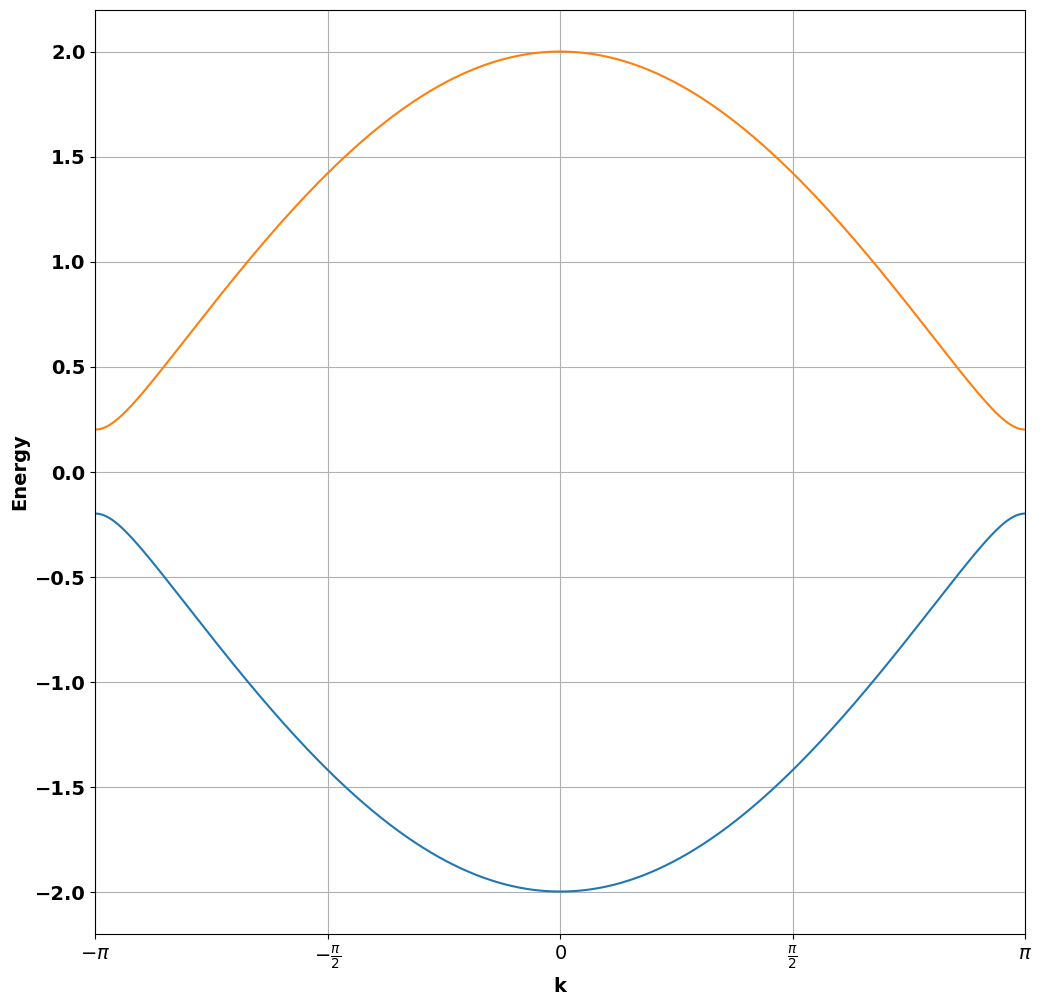

In [59]:
eigenvalues = generalHuckelBand(kgrid, metallic=False, ring=False)
plot(kgrid, eigenvalues)

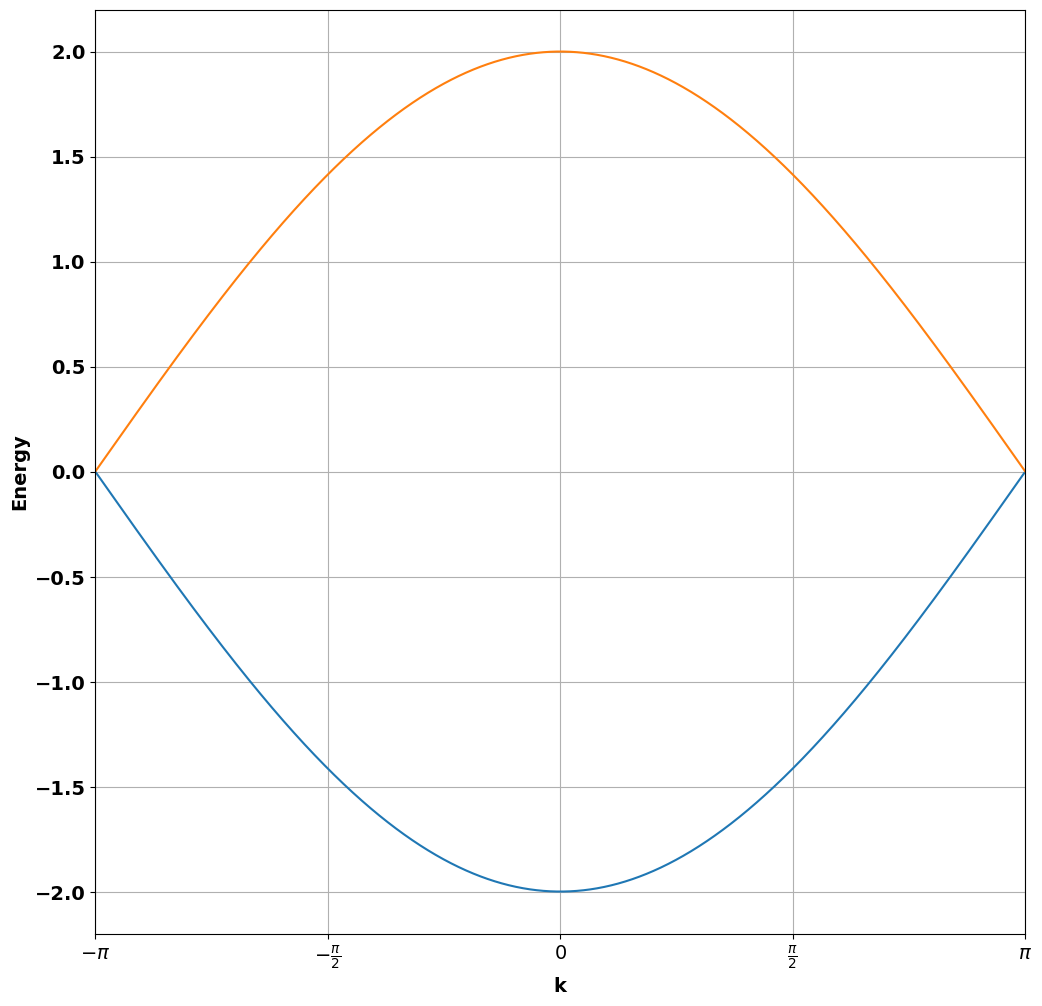

In [60]:
eigenvalues = generalHuckelBand(kgrid, metallic=True, ring=False)
plot(kgrid, eigenvalues, metallic=True)


[4 1 2 3]


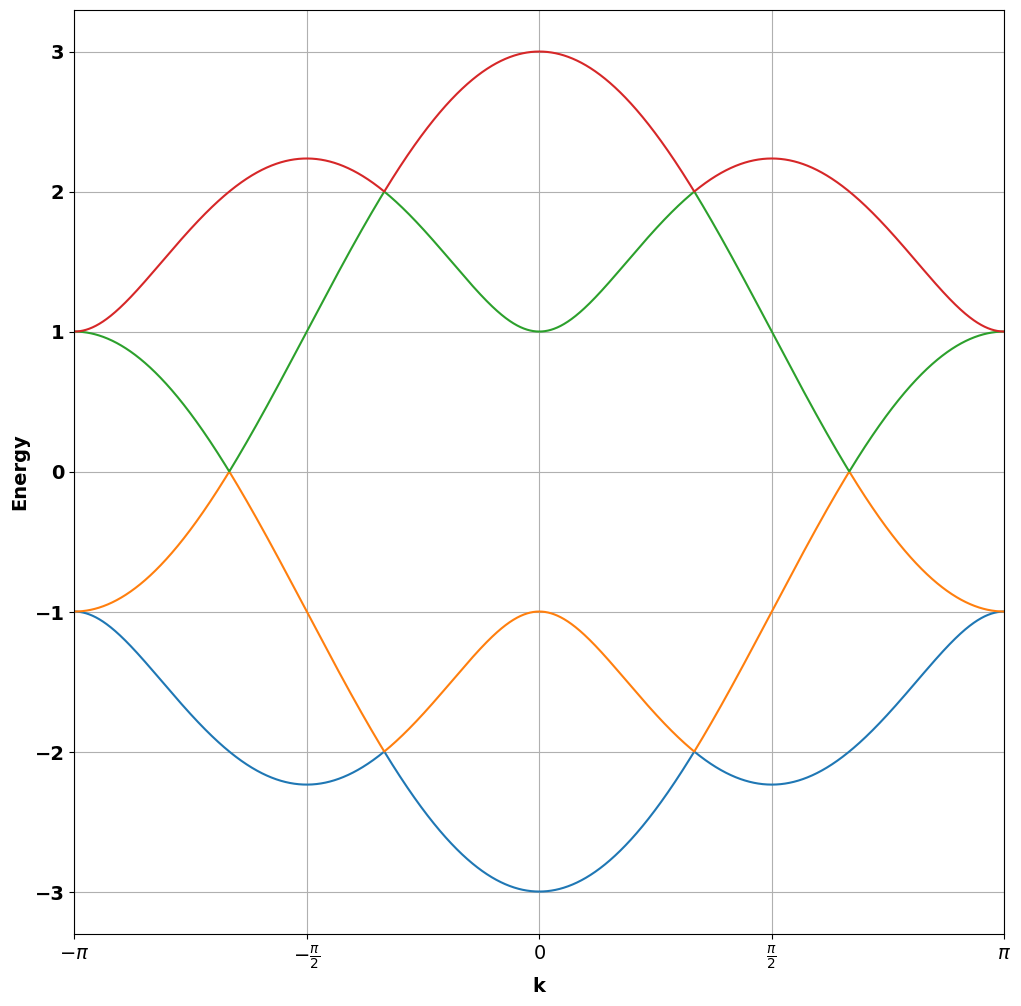

In [61]:
eigenvalues = generalHuckelBand(kgrid, metallic=False, ring=True, num=4)
plot(kgrid, eigenvalues)

[6 1 2 3 4 5]


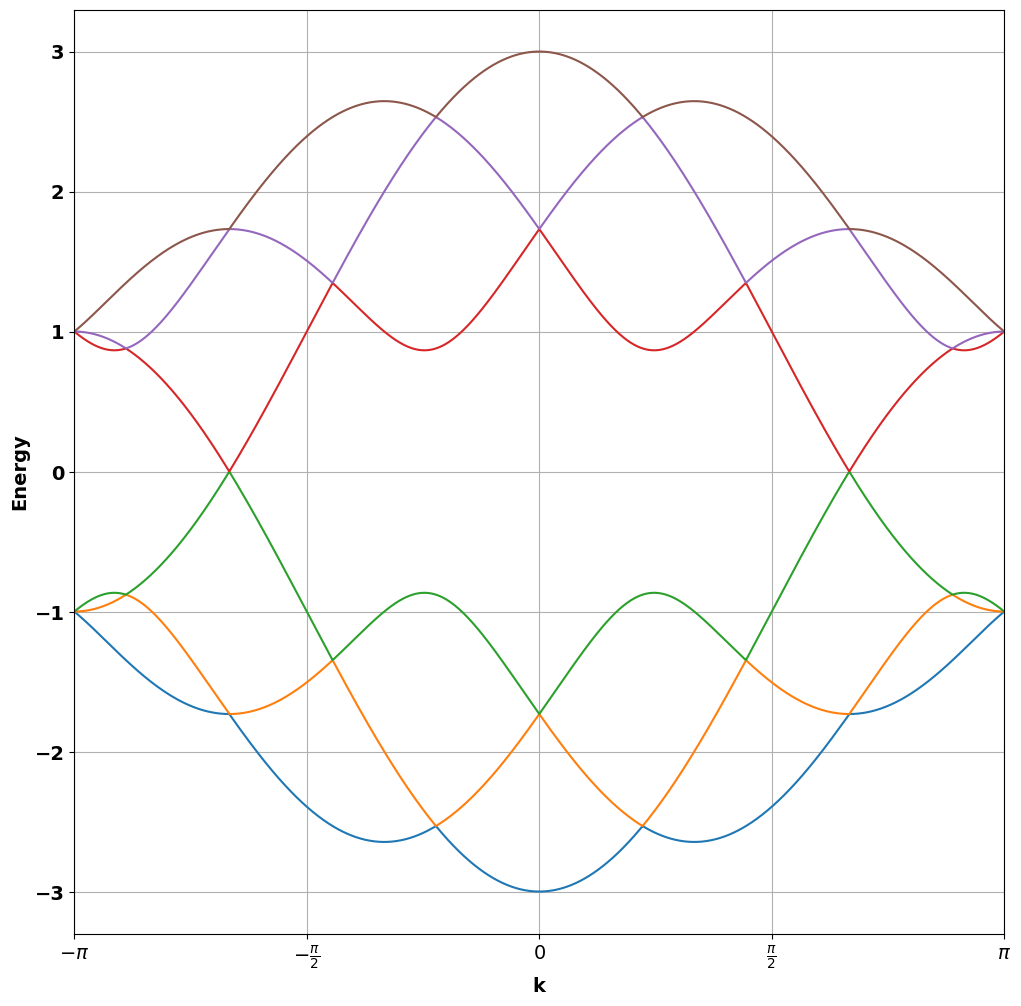

In [62]:
eigenvalues = generalHuckelBand(kgrid, metallic=False, ring=True, num=6)
plot(kgrid, eigenvalues)

[8 1 2 3 4 5 6 7]


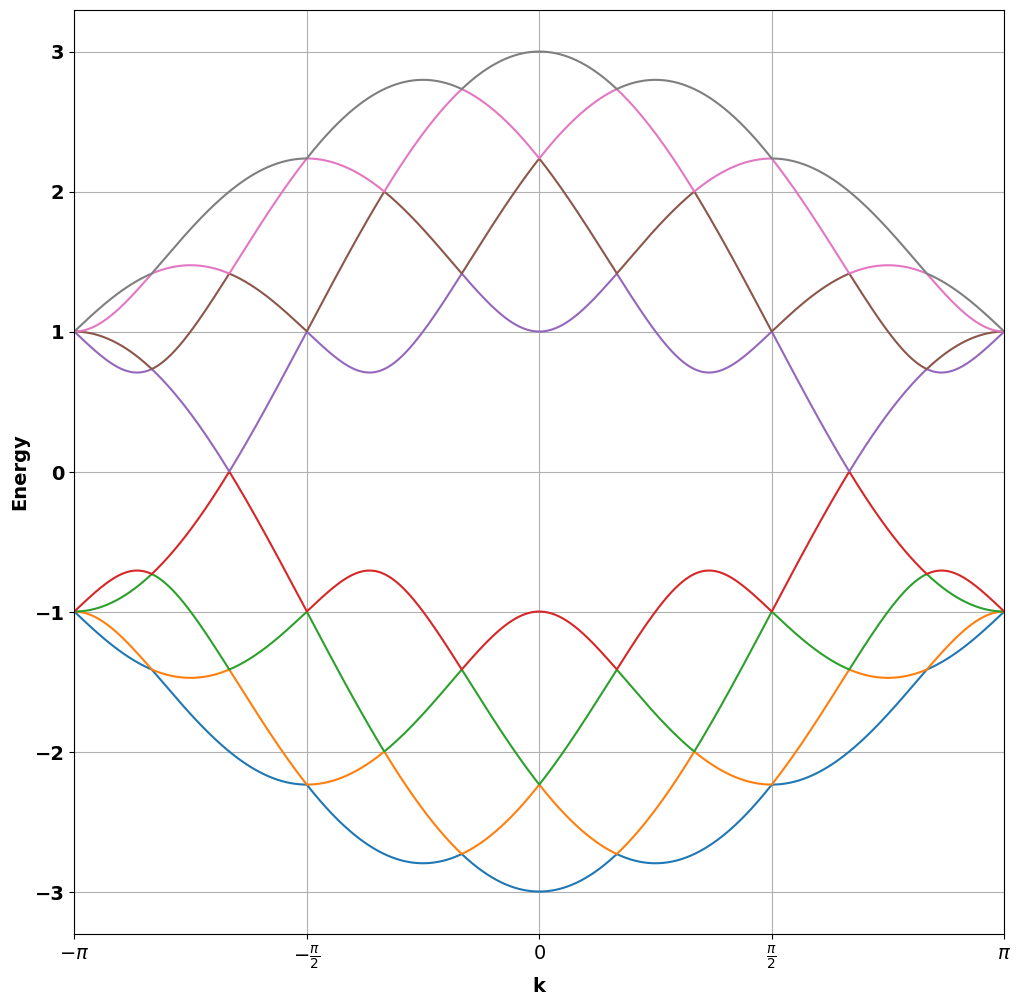

In [63]:
eigenvalues = generalHuckelBand(kgrid, metallic=False, ring=True, num=8)
plot(kgrid, eigenvalues)

[10  1  2  3  4  5  6  7  8  9]


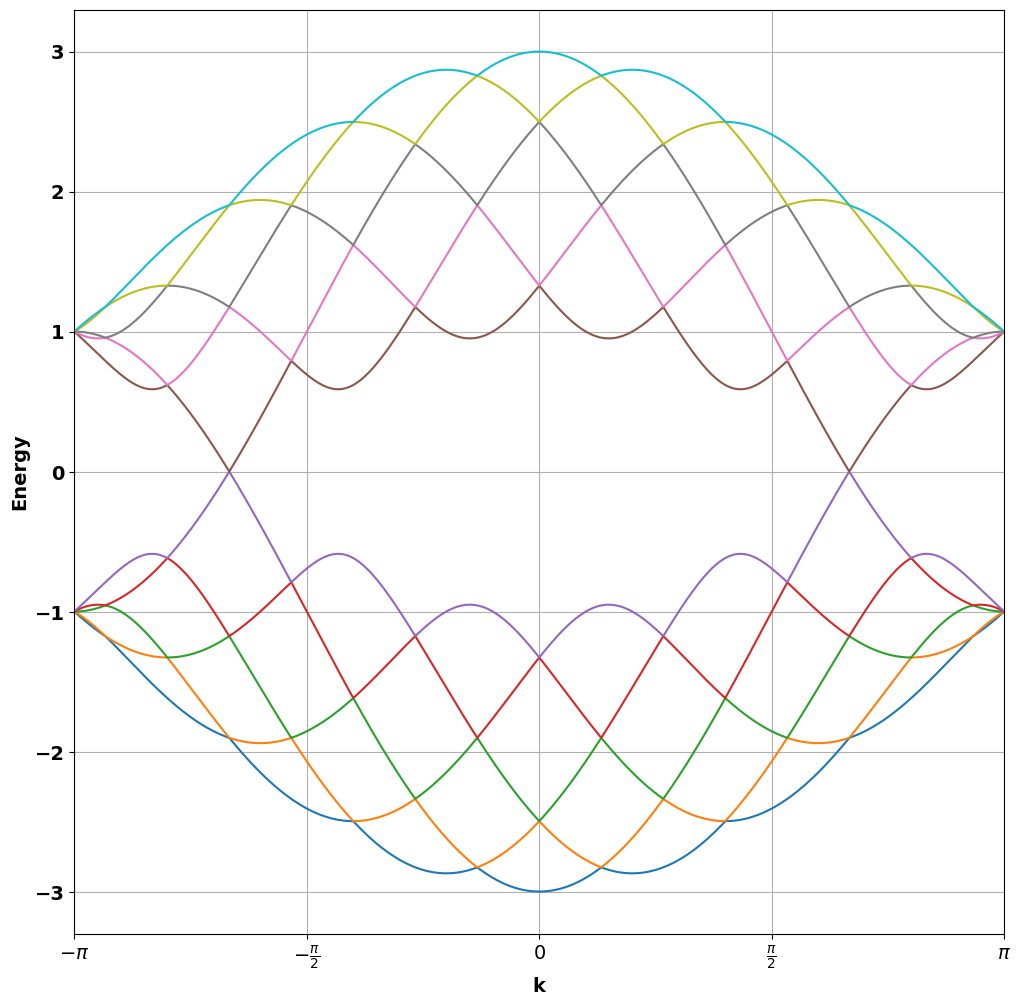

In [64]:
eigenvalues = generalHuckelBand(kgrid, metallic=False, ring=True, num=10)
plot(kgrid, eigenvalues)


# Part 3


In [65]:

mat = np.eye(2, dtype=np.complex128)[::-1]*-1
mat1 = np.zeros((2, 2), dtype=np.complex128)
mat1[0][1] = -1
mat2 = np.zeros((2, 2), dtype=np.complex128)
mat2[1][0] = -1

kgrid = np.linspace(-np.pi, np.pi, 100)
eigenvalues = np.zeros((len(kgrid), len(kgrid), 2), dtype=np.float64)
for i in range(len(kgrid)):
    for j in range(len(kgrid)):
        dkmat = np.zeros((2, 2), dtype=np.complex128)
        dkmat = mat2*np.exp(-1j*kgrid[i]) + mat1*np.exp(-1j*kgrid[j]) + mat + mat1*np.exp(1j*kgrid[i]) + mat2*np.exp(1j*kgrid[j])
        eigvals = np.sort(scipy.linalg.eigvals(dkmat).real)
        eigenvalues[i][j] = eigvals




C:\Users\omkar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


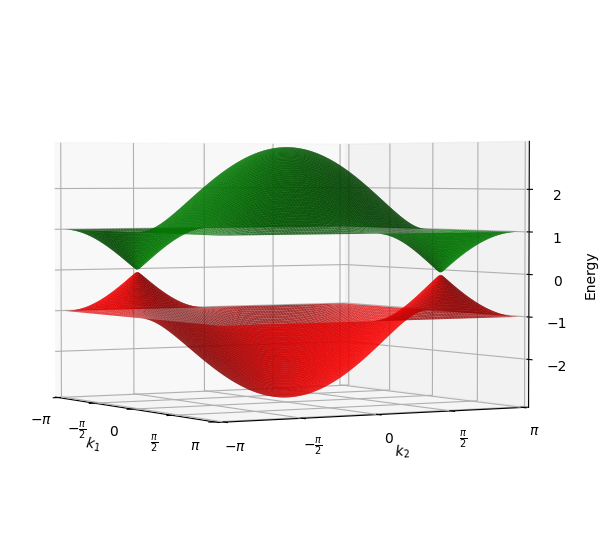

In [66]:
# kgrid = np.linspace(-np.pi, np.pi, 100)
K1, K2 = np.meshgrid(kgrid, kgrid)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K1, K2, eigenvalues[:, :, 0], rstride=1, cstride=1, color='red', alpha=0.8, edgecolor='none')
ax.plot_surface(K1, K2, eigenvalues[:, :, 1], rstride=1, cstride=1, color='green', alpha=0.8, edgecolor='none')
ax.set_xlabel('$k_1$')
ax.set_xlim(-np.pi, np.pi)
ax.set_xticks(np.arange(-np.pi, np.pi+0.1, np.pi/2))
ax.set_xticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_ylabel('$k_2$')
ax.set_ylim(-np.pi, np.pi)
ax.set_yticks(np.arange(-np.pi, np.pi+0.1, np.pi/2))
ax.set_yticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_zlabel('Energy')
# ax.set_title('2D Band Structure')
ax.view_init(elev=2, azim=-30)

plt.tight_layout()
plt.savefig('2D_band_structure.png', dpi=300, bbox_inches='tight')
plt.show()


# Part 4

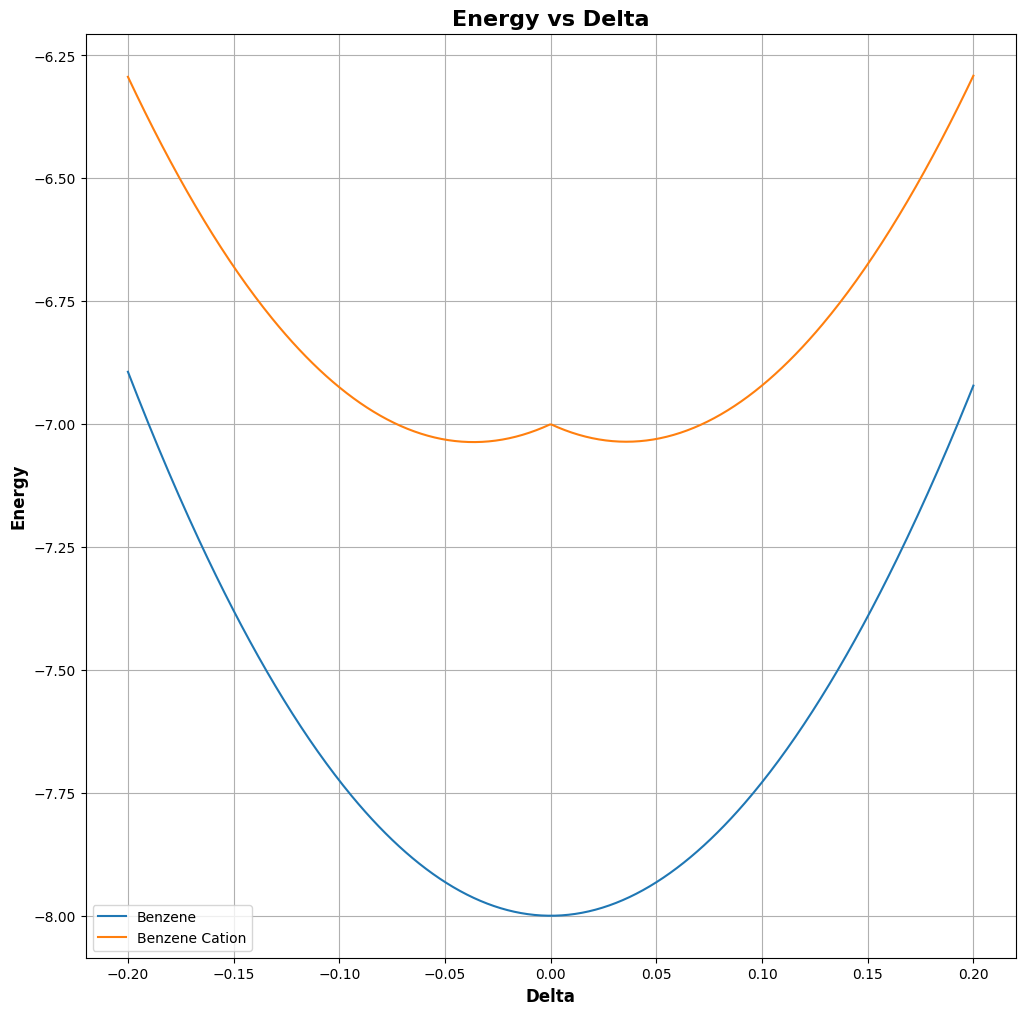

In [67]:
matrix = read_file('benzene.txt', 0, -1)
bond1 = [2, 3]
bond2 = [5, 6]
k = 10.0
deltas = np.linspace(-0.2, 0.2, 500)
eigenvalues = np.zeros((len(deltas), 6), dtype=np.float64)
energies = np.zeros((len(deltas), 2), dtype=np.float64)
for i in range(len(deltas)):
    delta_mat = np.zeros((6, 6), dtype=np.float64)
    for j in range(6):
        for k in range(6):
            if matrix[j][k] != 0:
                if (j+k==5) or (j+k==10):
                    # if i == 100:print(j, k, deltas[i])
                    delta_mat[j][k] = -2*deltas[i]
                    delta_mat[k][j] = -2*deltas[i]
                    # if i == 100:print(delta_mat)
                    
                else:
                    delta_mat[j][k] = deltas[i]
                    delta_mat[k][j] = deltas[i]
                    
        # print(delta_mat)
    ssh = matrix + delta_mat
    eigvals, eigvecs = diagonalize(ssh)
    eigenvalues[i] = eigvals.real
    energies[i][0] = 2*(eigenvalues[i][0] + eigenvalues[i][1] + eigenvalues[i][2]) + (1/2)*k*(12*deltas[i]**2)
    energies[i][1] = 2*(eigenvalues[i][0] + eigenvalues[i][1]) + eigenvalues[i][2] + (1/2)*k*(12*deltas[i]**2)  


plt.figure(figsize=(12, 12))
plt.plot(deltas, energies[:, 0], label='Benzene')
plt.plot(deltas, energies[:, 1], label='Benzene Cation')
plt.xlabel('Delta', fontsize=12, fontweight='bold')
plt.ylabel('Energy', fontsize=12, fontweight='bold')
plt.title('Energy vs Delta', fontsize=16, fontweight='bold')
plt.legend()
plt.grid()
plt.savefig('ssh_benzene.png', dpi=300, bbox_inches='tight')
plt.show()



# Part 5

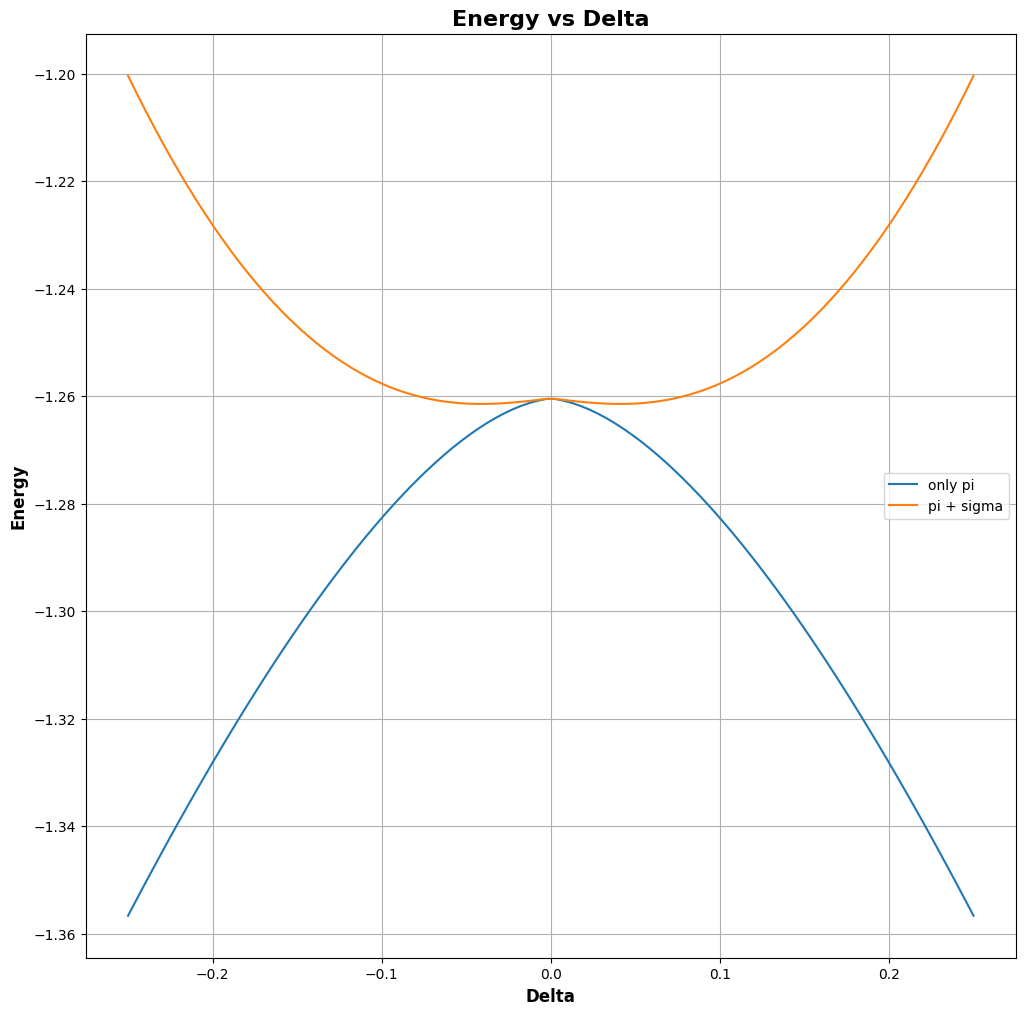

In [68]:
kgrid = np.linspace(-np.pi, np.pi, 100)
dgrid = np.linspace(-0.25, 0.25, 100)
energies = np.zeros((len(dgrid), 2), dtype=np.float64)
K = 2.5
for i in range(len(dgrid)):
    e1 = []
    for j in range(len(kgrid)):
        dkmat = np.zeros((2, 2), dtype=np.complex128)
        dkmat[0][1] = (-1+dgrid[i]) + (-1-dgrid[i])*np.exp(-1j*kgrid[j])
        dkmat[1][0] = (-1+dgrid[i]) + (-1-dgrid[i])*np.exp(1j*kgrid[j])

        eigvals = np.sort(scipy.linalg.eigvals(dkmat).real)
        e1.append(eigvals[0])
    e_pi = sum(e1)/len(e1)
    energies[i][0] = e_pi
    energies[i][1] = (e_pi) + sum([K*dgrid[i]**2*(1/len(kgrid)) for k in kgrid])

plt.figure(figsize=(12, 12))
plt.plot(dgrid, energies[:, 0], label='only pi')
plt.plot(dgrid, energies[:, 1], label='pi + sigma')
plt.xlabel('Delta', fontsize=12, fontweight='bold')
plt.ylabel('Energy', fontsize=12, fontweight='bold')
plt.title('Energy vs Delta', fontsize=16, fontweight='bold')
plt.legend()
plt.grid()
plt.savefig('ssh_polyacetylene.png', dpi=300, bbox_inches='tight')
plt.show()


